In [1]:
import pickle
import h5py
import numpy as np
import pandas as pd
from sklearn.preprocessing  import LabelEncoder, OneHotEncoder
from matplotlib import pyplot as plt

import random
import itertools
import functools
import time

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import gudhi.wasserstein as wasserstein
from torch_topological import nn as topnn

from advtopo import utils
from advtopo import models
from advtopo import pis

In [3]:
ds_train, ds_test = utils.get_torch_datasets()

/home/andrea/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [4]:
def assemble_adv(adv_h0_deaths, adv_h1, adv_h1_added_bars_birth, device):

    adv_h0_deaths_c = torch.clamp(adv_h0_deaths, min=0., max=1.)

    adv_h1_c2 = adv_h1.clone()
    adv_h1_c = adv_h1.clone()
    adv_h1_c[0] = torch.clamp(adv_h1[0], min=0., max=1.)
    adv_h1_c2[1] = torch.clamp(adv_h1[1], min=0., max=1.)
    adv_h1_c[1] = torch.clamp(adv_h1_c2[1], min=adv_h1_c2[0])

    if adv_h1_added_bars_birth != None:
        adv_h1_added_bars_birth_c = torch.clamp(adv_h1_added_bars_birth, min=0., max=1.)

    ptb0 = torch.vstack((torch.zeros(adv_h0_deaths_c.shape[0]).to(device), adv_h0_deaths_c))

    if adv_h1_added_bars_birth != None:
        short_bars = torch.vstack((adv_h1_added_bars_birth_c, adv_h1_added_bars_birth_c + 0.000001))
        ptb1 = torch.hstack((adv_h1_c, short_bars))
    else:
        ptb1 = adv_h1_c

    return (ptb0, ptb1)

def get_adv(arch, model_config, sample, model, lamb, n_added_bars, wass_p, wass_q, n_iterations, lr, device):

    (X, y) = sample

    # Check how the sample is classified, if it is not correctly classified we move on

    if arch=="PI":
        X_vec = pis.preprocess_x(X, device, model_config["centers"], model_config["sigma"], model_config["mean"], model_config["var"], model_config["weighted"]).float()
        output = model(X_vec)
    else:
        output = model((X[0].unsqueeze(0).to(device), X[1].unsqueeze(0).to(device)))

    if torch.argmax(y) == torch.argmax(output):

        # Initialize objects we will need
        loss_f = nn.CrossEntropyLoss()
        wass = topnn.WassersteinDistance(p=wass_p, q=wass_q)
        top_x_h0 = topnn.PersistenceInformation(pairing=None, diagram=X[0].T) # H0 diagram in format that we can use to compute Wasserstein later on
        top_x_h1 = topnn.PersistenceInformation(pairing=None, diagram=X[1].T) # H1 diagram in format that we can use to compute Wasserstein later on

        # Initialize differentiable tensors
        adv_h0_deaths = X[0].clone()[1]
        adv_h1 = X[1].clone()
        
        adv_h0_deaths.requires_grad = True
        adv_h1.requires_grad = True
        tensors_to_optimize = [adv_h0_deaths, adv_h1]

        if n_added_bars > 0:
            adv_h1_added_bars_birth = torch.linspace(0.05, 0.95, n_added_bars).float().to(device)
            adv_h1_added_bars_birth.requires_grad = True
            tensors_to_optimize.append(adv_h1_added_bars_birth)

        optim = torch.optim.Adam(tensors_to_optimize, lr=lr, eps=1e-04)

        # Setup trackers
        losses_h0, losses_h1, losses_nn, losses_combined, classes = [np.zeros(n_iterations) for i in range(5)]

        for i in range(n_iterations):
            #print("iteration", i)

            # Assemble the perturbed sample from the differentiable (and now updated) parts
            if n_added_bars > 0:
                perturbed = assemble_adv(adv_h0_deaths, adv_h1, adv_h1_added_bars_birth, device)
            else:
                perturbed = assemble_adv(adv_h0_deaths, adv_h1, None, device)

            if arch=="PI":
                output_pert = model(pis.preprocess_x(perturbed, device, model_config["centers"], model_config["sigma"], model_config["mean"], model_config["var"], model_config["weighted"]).float())
            else:
                output_pert = model((perturbed[0].unsqueeze(0), perturbed[1].unsqueeze(0)))

            # Compute losses
            if arch=="PI":
                nn_loss = -loss_f(output_pert,y)
            else:
                nn_loss = -loss_f(output_pert,y.unsqueeze(0))

            top_perturbed_h0 = topnn.PersistenceInformation(pairing=None, diagram=perturbed[0].T)
            top_perturbed_h1 = topnn.PersistenceInformation(pairing=None, diagram=perturbed[1].T)
            loss_h0 = wass(top_x_h0, top_perturbed_h0)
            loss_h1 = wass(top_x_h1, top_perturbed_h1)

            if i==0:
                combined_loss = nn_loss
            else:
                combined_loss = nn_loss + lamb * (loss_h0 + loss_h1)


            losses_h0[i], losses_h1[i], losses_nn[i], losses_combined[i], classes[i] = loss_h0, loss_h1, nn_loss, combined_loss, torch.argmax(output_pert)

            # Get gradients and take step
            optim.zero_grad()
            combined_loss.backward()
            optim.step()

        if (classes!=torch.argmax(y).cpu().numpy()).any():
            mask = (classes!=torch.argmax(y).cpu().numpy())
            wass_losses = losses_h0 + losses_h1
            ind = wass_losses[mask].argmin()

            return perturbed, classes[mask][ind], losses_h0[mask][ind], losses_h1[mask][ind], losses_h0, losses_h1, losses_nn, losses_combined, classes
        
        else:
            return None, None, None, None, losses_h0, losses_h1, losses_nn, losses_combined, classes
        
    return [None]*9
    
    


### Settings

In [4]:
device = torch.device("cpu")

In [7]:
arch = "PI" # DeepSet/PI
weighted = True

lamb = 10
n_added_bars = 3

wass_p = 1
wass_q = 1

n_iterations = 50

lr = 0.0001


if arch=="DeepSet":
    model = models.Model_DeepSet().to(device)
    model.load_state_dict(torch.load("./model_deepset"))
    model_config = {}
else:
    

    if weighted:
        with open('model_config_weighted', 'rb') as handle:
            model_config = pickle.load(handle)
        model = models.Model_PI(model_config["x_n"]*model_config["y_n"]*2).to(device)
        model.load_state_dict(torch.load("./model_pi_weighted"))
    else:
        with open('model_config_unweighted', 'rb') as handle:
            model_config = pickle.load(handle)
        model = models.Model_PI(model_config["x_n"]*model_config["y_n"]*2).to(device)
        model.load_state_dict(torch.load("./model_pi_unweighted"))
    

model.eval()
print("x")

x


In [10]:
n_samples = 2 # Number of samples to try to find adversarial examples for (it is quite expensive to run so we don't do it for the whole dataset)
printit = True

h0_dists = []
h1_dists = []
classes_from = []
classes_to = []

i = 0
while len(h0_dists) < n_samples:
    #print("i =", i)
    sample = ds_test[i]


    if printit:
        print("class:", torch.argmax(sample[1]))
    perturbed, class_perturbed, h0_dist, h1_dist, losses_h0, losses_h1, losses_nn, losses_combined, classes = get_adv(arch, model_config, sample, model, lamb, n_added_bars, wass_p, wass_q, n_iterations, lr, device)

    if type(classes)!=np.ndarray and classes==None:
        if printit:
            print("Already wrongly classified")

    elif perturbed!=None:
        if printit:
            print("Found perturbed classified as ", int(class_perturbed), "at distance:", h0_dist, "(H0),", h1_dist, "(H1)")
        h0_dists.append(h0_dist)
        h1_dists.append(h1_dist)
        classes_from.append(int(torch.argmax(sample[1]).numpy()))
        classes_to.append(int(class_perturbed))


    else:
        if printit:
            print("Failed to find adv example")
        h0_dists.append(None)
        h1_dists.append(None)
        classes_from.append(int(torch.argmax(sample[1]).numpy()))
        classes_to.append(None)

    i += 1

h0_dists = np.array(h0_dists)
h1_dists = np.array(h1_dists)
classes_from = np.array(classes_from)
classes_to = np.array(classes_to)

class: tensor(0)
Failed to find adv example
class: tensor(3)
Found perturbed classified as  0 at distance: 0.0 (H0), 3.0249357223510742e-06 (H1)


In [190]:
(h1_dists==None).sum()/h1_dists.shape[0]

0.7

In [191]:
h0_dists[h0_dists!=None].mean()

0.007022782927379012

In [192]:
h1_dists[h1_dists!=None].mean()

0.02972896893819173

In [187]:
classes_from[classes_to==None]

array([4, 4, 2, 4, 1, 1, 1, 4, 0, 0, 4, 0, 1])

In [117]:
classes_to

array([2, 2, None, None, 2, 2, None, None, None, 2, None, 2, 4, 2, None,
       2, 2, 4, 2, None], dtype=object)

In [60]:
classes_con = np.vstack((classes_from, classes_to))

In [68]:
classes_con[:, :30]

array([[4, 4, 2, 4, 4, 2, 2, 1, 1, 2, 1, 4, 0, 2, 0, 4, 2, 0, 1, 4, 4, 3,
        4, 2, 4, 3, 1, 4, 0, 4],
       [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        None, 3, 3, 3, None, 3, 3, 3, 3]], dtype=object)

Text(0.5, 1.0, 'Classes')

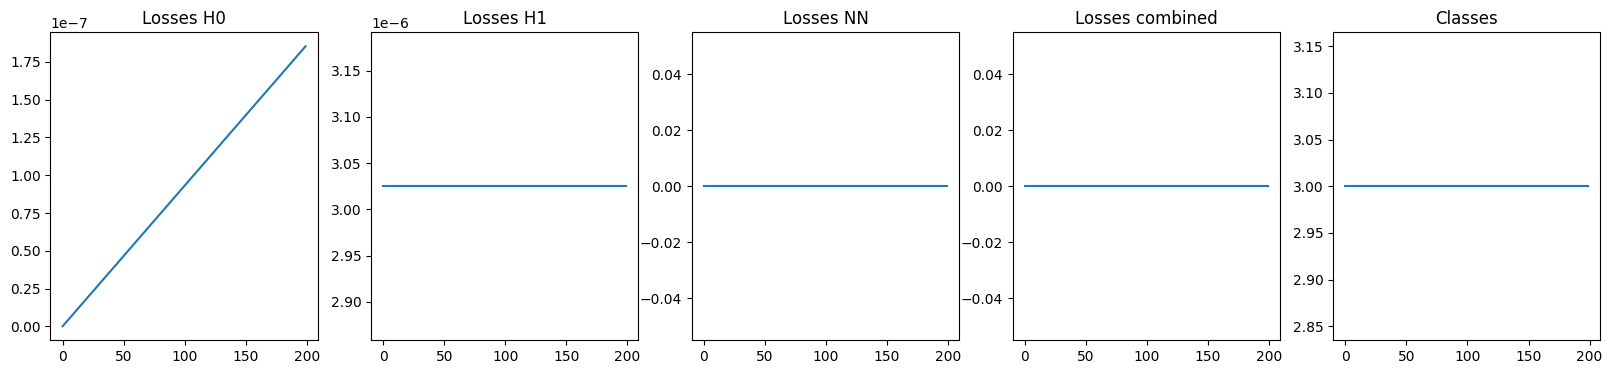

In [89]:
plt.figure(figsize=(20,4))
plt.subplot(151)
plt.plot(losses_h0)
plt.title("Losses H0")
plt.subplot(152)
plt.plot(losses_h1)
plt.title("Losses H1")
plt.subplot(153)
plt.plot(losses_nn)
plt.title("Losses NN")
plt.subplot(154)
plt.plot(losses_combined)
plt.title("Losses combined")
plt.subplot(155)
plt.plot(classes)
plt.title("Classes")

# Trash

In [70]:
pi_X = pis.preprocess_x(sample[0], device, model_config["centers"], model_config["sigma"], model_config["mean"], model_config["var"], model_config["weighted"], False).float()
pi_pert = pis.preprocess_x(perturbed, device, model_config["centers"], model_config["sigma"], model_config["mean"], model_config["var"], model_config["weighted"], False).float()


In [65]:
pi_pert

tensor([ 0.0000,  0.0000,  0.0000,  ...,  0.0750,  1.6398, 27.6281],
       grad_fn=<ToCopyBackward0>)

In [71]:
pi_X = pi_X.numpy()
pi_pert = pi_pert.detach().numpy()

In [67]:
model(pi_pert)

tensor([ 3.3718e+09, -4.4344e+09, -2.0441e+09,  1.6544e+08, -7.0130e+08],
       grad_fn=<AddBackward0>)

In [27]:
X = sample[0]

In [28]:
perturbed[1].shape

torch.Size([2, 503])

In [29]:
(X[1]==perturbed[1][:,:500]).all()

tensor(True)

In [30]:
X[1]

tensor([[0.0066, 0.0084, 0.0100, 0.0216, 0.0107, 0.0067, 0.0054, 0.0100, 0.0071,
         0.0079, 0.0139, 0.0100, 0.0103, 0.0111, 0.0061, 0.0054, 0.0061, 0.0088,
         0.0104, 0.0082, 0.0116, 0.0096, 0.0069, 0.0096, 0.0062, 0.0235, 0.0091,
         0.0126, 0.0038, 0.0091, 0.0050, 0.0126, 0.0139, 0.0114, 0.0070, 0.0040,
         0.0132, 0.0125, 0.0066, 0.0078, 0.0101, 0.0038, 0.0151, 0.0050, 0.0085,
         0.0050, 0.0034, 0.0065, 0.0074, 0.0068, 0.0181, 0.0086, 0.0180, 0.0070,
         0.0068, 0.0089, 0.0137, 0.0074, 0.0056, 0.0069, 0.0164, 0.0086, 0.0079,
         0.0054, 0.0129, 0.0097, 0.0145, 0.0034, 0.0056, 0.0051, 0.0067, 0.0038,
         0.0044, 0.0081, 0.0143, 0.0100, 0.0087, 0.0070, 0.0063, 0.0066, 0.0046,
         0.0062, 0.0196, 0.0107, 0.0068, 0.0120, 0.0099, 0.0099, 0.0082, 0.0091,
         0.0082, 0.0025, 0.0071, 0.0071, 0.0068, 0.0069, 0.0065, 0.0049, 0.0069,
         0.0043, 0.0051, 0.0101, 0.0055, 0.0118, 0.0057, 0.0097, 0.0046, 0.0110,
         0.0075, 0.0053, 0.0

In [31]:
perturbed[1][:,:500]

tensor([[0.0066, 0.0084, 0.0100, 0.0216, 0.0107, 0.0067, 0.0054, 0.0100, 0.0071,
         0.0079, 0.0139, 0.0100, 0.0103, 0.0111, 0.0061, 0.0054, 0.0061, 0.0088,
         0.0104, 0.0082, 0.0116, 0.0096, 0.0069, 0.0096, 0.0062, 0.0235, 0.0091,
         0.0126, 0.0038, 0.0091, 0.0050, 0.0126, 0.0139, 0.0114, 0.0070, 0.0040,
         0.0132, 0.0125, 0.0066, 0.0078, 0.0101, 0.0038, 0.0151, 0.0050, 0.0085,
         0.0050, 0.0034, 0.0065, 0.0074, 0.0068, 0.0181, 0.0086, 0.0180, 0.0070,
         0.0068, 0.0089, 0.0137, 0.0074, 0.0056, 0.0069, 0.0164, 0.0086, 0.0079,
         0.0054, 0.0129, 0.0097, 0.0145, 0.0034, 0.0056, 0.0051, 0.0067, 0.0038,
         0.0044, 0.0081, 0.0143, 0.0100, 0.0087, 0.0070, 0.0063, 0.0066, 0.0046,
         0.0062, 0.0196, 0.0107, 0.0068, 0.0120, 0.0099, 0.0099, 0.0082, 0.0091,
         0.0082, 0.0025, 0.0071, 0.0071, 0.0068, 0.0069, 0.0065, 0.0049, 0.0069,
         0.0043, 0.0051, 0.0101, 0.0055, 0.0118, 0.0057, 0.0097, 0.0046, 0.0110,
         0.0075, 0.0053, 0.0

In [9]:
torch.linspace(0.05, 0.95, n_added_bars)

tensor([0.0500, 0.5000, 0.9500])

In [72]:
np.linalg.norm(pi_X - pi_pert, ord=2)

2.3630062e-06

In [33]:
diff  = pi_X - pi_pert

In [36]:
np.sort(diff)

array([-1.0578084e-06, -1.0430813e-06, -9.5818268e-07, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32)

In [13]:
sigma = model_config["sigma"]

In [48]:
mu = model_config["centers"][2497]

In [49]:
mu

tensor([[0.9592, 0.0000]], dtype=torch.float64)

In [66]:
p = torch.tensor([0.95, 0.00001])

In [81]:
ret = torch.pow(p - mu, 2)

In [82]:
ret

tensor([[8.4340e-05, 1.0000e-10]], dtype=torch.float64)

In [83]:
ret = -torch.sum(ret) / (2*torch.pow(sigma,2))

In [84]:
ret

tensor(-0.4217, dtype=torch.float64)

In [87]:
ret = torch.exp(ret)/(2*torch.pi*torch.sqrt(sigma))

In [88]:
ret

tensor(1.0439, dtype=torch.float64)

In [92]:
import scipy.stats

In [105]:
scipy.stats.norm(0.025, 0.01).pdf(0)

1.752830049356854

In [27]:
diff[4900]

-4420.9956

In [28]:
pi_X[-100:]

array([9.9965283e+02, 5.9253357e+02, 9.2732954e+00, 9.8123141e-03,
       1.0130385e-06, 3.6567429e-12, 2.4835509e-19, 2.7212112e-28,
       4.6660815e-39, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 1.0724755e+03, 7.5077606e+02,
       2.0451015e+01, 4.4124197e-02, 6.2541194e-06, 2.4220164e-11,
       1.6653297e-18, 1.8286389e-27, 3.1368366e-38, 0.0000000e

In [29]:
pi_pert[-100:]

array([5.42064844e+03, 1.76875256e+03, 1.52667427e+01, 3.60167166e-03,
       4.62931069e-07, 4.39077143e-11, 6.78753507e-17, 1.62971504e-24,
       6.07721534e-34, 4.20389539e-45, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.47248713e-34,
       5.06745855e-25, 2.70845816e-17, 2.24826442e-11, 2.89845048e-07,
       5.80333544e-05, 1.80460760e-04, 8.71527573e-06, 6.53691412e-09,
       7.61478622e-14, 1.37764055e-20, 3.87085949e-29, 1.68916581e-39,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.40129846e-45, 1.80142879e-34, 5.98652785e-25, 3.08977039e-17,
       2.47668448e-11, 3.08324786e-07, 5.96127938e-05, 1.79004448e-04,
       8.34797993e-06, 6.04633632e-09, 3.80029492e+03, 1.11955029e+03,
       1.05004234e+01, 3.92345898e-03, 3.57105409e-06, 3.52232715e-10,
      

In [45]:
classes

array([3., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [63]:
adv_h0_deaths.shape[0]

500

In [31]:
torch.argmax(y) == torch.argmax(output)

tensor(True)